<img width="8%" alt="Plotly.png" src="https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/.github/assets/logos/Plotly.png" style="border-radius: 15%">

# Plotly - Follow deal opportunities by day

**Tags:** #plotly #html #csv #image #content #analytics #cohorts

**Author:** [Florent Ravenel](https://www.linkedin.com/in/florent-ravenel/)

**Description:** This notebook creates a chart to follow your deals by days over the last 2 weeks.

## Input

### Import libraries

In [1]:
import plotly.graph_objects as go
from naas_drivers import gsheet
import pandas as pd
import os
from datetime import date, datetime, timedelta
import naas_data_product

✅ utils file '/home/ftp/abi/utils/data.ipynb' successfully loaded.
✅ utils file '/home/ftp/abi/utils/llm.ipynb' successfully loaded.
✅ utils file '/home/ftp/abi/utils/naas_chat_plugin.ipynb' successfully loaded.
✅ utils file '/home/ftp/abi/utils/naas_lab.ipynb' successfully loaded.


### Setup variables
**Inputs**
- `entity_dir`: This variable represents the entity directory.
- `entity_name`: This variable holds the entity name.
- `input_dir`: Input directory to retrieve file from.
- `input_file`: Name of the file to be retrieved.
- `linkedin_url`: This variable stores the LinkedIn profile URL that will be used as image source.
- `title`: Graph title

**Outputs**
- `output_dir`: This variable is used for storing the path to the directory where the output files will be saved.

In [2]:
# Inputs
entity_dir = pload(os.path.join(naas_data_product.OUTPUTS_PATH, "entities", "0"), "entity_dir")
entity_name = pload(os.path.join(naas_data_product.OUTPUTS_PATH, "entities", "0"), "entity_name")
input_dir = os.path.join(entity_dir, "sales-engine", date.today().isoformat())
input_file = "deals"
linkedin_url = pload(os.path.join(naas_data_product.OUTPUTS_PATH, "entities", "0"), "linkedin_url")
title = "New Opportunities"

# Outputs
output_dir = os.path.join(entity_dir, "sales-engine", date.today().isoformat())

## Model

### Set outputs

In [3]:
csv_output = os.path.join(output_dir, "deals_trend")
html_output = os.path.join(output_dir, "deals_trend.html")
image_output = os.path.join(output_dir, "deals_trend.png")

### Get sales qualified leads

In [4]:
df_input = pload(input_dir, input_file) 
# Filter on entity
if len(df_input) > 0:
    df_input = df_input[(df_input["ENTITY"] == entity_name)]
    
print("⚡️ Deals DB:", len(df_input))
df_input.head(3)

⚡️ Deals DB: 62


,ENTITY,SCENARIO,DEAL_NAME,DEAL_CREATED_DATE,DEAL_SCORE,PEOPLE_FULLNAME,PEOPLE_OCCUPATION,PEOPLE_SENIORITY,PEOPLE_DEPARTMENT,PEOPLE_NOTES,MESSAGING_OPTIONS,ORG_NAME,ORG_STAFF_RANGE_NAME,ORG_INDUSTRY,ORG_COUNTRY,PEOPLE_PROFILE_URL,ORG_LINKEDIN_URL,CRM_CONTACT_ID,CRM_ORG_ID,CRM_DEAL_ID
0,Jérémy Ravenel,W04-2024,Anthony Alcaraz (Fribl),2024-01-22,99,Anthony Alcaraz,Chief Product Officer - AI Architect | @Fribl ...,Executive,Product Management,"[""Anthony Alcaraz commented '💕 ' on 'I wish w...","1. Hi Anthony, I noticed your comment on Jérém...",Fribl,Micro Team (2-10),"Technology, Information and Internet",France,https://www.linkedin.com/in/ACoAACVPJNABGwj10w...,https://www.linkedin.com/company/fribl,TBD,TBD,TBD
1,Jérémy Ravenel,W04-2024,Matteo Castiello (33A),2024-01-22,64,Matteo Castiello,Generative AI Advisor and Researcher | Guiding...,Professional/Staff,Research and Development (R&D),"[""Matteo Castiello sent 'praise' reaction to '...","1. Hi Matteo, I noticed your expertise in Gene...",33A,Micro Team (2-10),Design Services,Denmark,https://www.linkedin.com/in/ACoAACenYg8BoVOSWA...,https://www.linkedin.com/company/33a,TBD,TBD,TBD
2,Jérémy Ravenel,W04-2024,Vin Vashishta (V Squared),2024-01-22,57,Vin Vashishta,AI Advisor | Author “From Data To Profit” | Co...,Executive,Education,['Vin Vashishta sent \'like\' reaction to \'We...,"1. ""Hi Vin, I couldn't agree more with your th...",V Squared,Micro Team (2-10),Business Consulting and Services,United States,https://www.linkedin.com/in/ACoAAADS0WQBhQQVMD...,https://www.linkedin.com/company/endgame-engin...,TBD,TBD,TBD


### Create trend dataframe

In [13]:
DATE_FORMAT = "%Y-%m-%d"
PERIOD = "%Y-%m-%d"
PERIOD_TEXT = "This day"

def get_trend(
    df_init,
    col_date,
    col_value,
    agg_value,
    entity_name
):
    # Init variable
    df = df_init.copy()

    # Groupby period
    if agg_value == "sum":
        df[col_value] = df[col_value].astype(float)
    df[col_date] = pd.to_datetime(df[col_date]).dt.strftime(DATE_FORMAT)
    df = df.groupby(col_date, as_index=False).agg({col_value: agg_value})

    # Rename column
    to_rename = {col_date: "DATE", col_value: "VALUE"}
    df = df.rename(columns=to_rename)

    # Reindex value
    d = datetime.now().date()
    d2 = date.today() - timedelta(days=date.today().weekday() + 7)
    idx = pd.date_range(d2, d, freq="D")
    df.set_index("DATE", drop=True, inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df["DATE"] = pd.DatetimeIndex(df.index)

    # Groupby month
    df["DATE"] = pd.to_datetime(df["DATE"], format=DATE_FORMAT).dt.strftime(PERIOD)
    df = df.groupby("DATE", as_index=False).agg({"VALUE": "sum"})

    # Calc variation
    df.loc[:, "VALUE_COMP"] = 0.
    df.loc[:, "VARV"] = 0.
    df.loc[:, "VARP"] = 1.
    for index, row in df.iterrows():
        if index > 0:
            n = df.loc[df.index[index], "VALUE"]
            n_1 = df.loc[df.index[index - 1], "VALUE"]
            df.loc[df.index[index], "VALUE_COMP"] = n_1
            df.loc[df.index[index], "VARV"] = n - n_1
            if n_1 > 0:
                df.loc[df.index[index], "VARP"] = (n - n_1) / abs(n_1)
    df = df.fillna(0.)

    # Plotly: Date display
    df["DATE_D"] = pd.to_datetime(df["DATE"], format=PERIOD).dt.strftime("%a %d %b")

    # Plotly: Value display
    df["VALUE_D"] = (
        "<b><span style='font-family: Arial;'>"
        + df["VALUE"].map("{:,.0f}".format).str.replace(",", " ")
        + "</span></b>"
    )

    # Plotly: Variation display
    df["VARV_D"] = df["VARV"].map("{:,.0f}".format).str.replace(",", " ")
    df.loc[df["VARV"] >= 0, "VARV_D"] = "+" + df["VARV_D"]
    df["VARP_D"] = df["VARP"].map("{:,.0%}".format).str.replace(",", " ")
    df.loc[df["VARP"] >= 0, "VARP_D"] = "+" + df["VARP_D"]

    # Plotly: hovertext
    df["TEXT"] = (
        "<b><span style='font-size: 14px;'>"
        + df["DATE_D"].astype(str)
        + ": "
        + df["VALUE_D"]
        + "</span></b><br>"
        "<span style='font-size: 12px;'>"
        + df["VARV_D"]
        + " ("
        + df["VARP_D"]
        + ")</span>"
    )
    
    # Add graph title
    df.insert(loc=0, column="ENTITY", value=entity_name)
    df.insert(loc=1, column="SCENARIO", value=pd.to_datetime(df["DATE"]).dt.strftime("W%W-%Y"))
    
    # Map colors
    df["COLOR"] = df["SCENARIO"].map(MAPPING_COLORS)
    return df.reset_index(drop=True)

df_trend = get_trend(
    df_input,
    "DEAL_CREATED_DATE",
    "DEAL_NAME",
    "count",
    entity_name
)
df_trend

,ENTITY,SCENARIO,DATE,VALUE,VALUE_COMP,VARV,VARP,DATE_D,VALUE_D,VARV_D,VARP_D,TEXT,COLOR
0,Jérémy Ravenel,W03-2024,2024-01-15,2,0.0,0.0,1.0,Mon 15 Jan,<b><span style='font-family: Arial;'>2</span></b>,+0,+100%,<b><span style='font-size: 14px;'>Mon 15 Jan: ...,#FFFDA2
1,Jérémy Ravenel,W03-2024,2024-01-16,1,2.0,-1.0,-0.5,Tue 16 Jan,<b><span style='font-family: Arial;'>1</span></b>,-1,-50%,<b><span style='font-size: 14px;'>Tue 16 Jan: ...,#FFFDA2
2,Jérémy Ravenel,W03-2024,2024-01-17,5,1.0,4.0,4.0,Wed 17 Jan,<b><span style='font-family: Arial;'>5</span></b>,+4,+400%,<b><span style='font-size: 14px;'>Wed 17 Jan: ...,#FFFDA2
3,Jérémy Ravenel,W03-2024,2024-01-18,2,5.0,-3.0,-0.6,Thu 18 Jan,<b><span style='font-family: Arial;'>2</span></b>,-3,-60%,<b><span style='font-size: 14px;'>Thu 18 Jan: ...,#FFFDA2
4,Jérémy Ravenel,W03-2024,2024-01-19,4,2.0,2.0,1.0,Fri 19 Jan,<b><span style='font-family: Arial;'>4</span></b>,+2,+100%,<b><span style='font-size: 14px;'>Fri 19 Jan: ...,#FFFDA2
5,Jérémy Ravenel,W03-2024,2024-01-20,2,4.0,-2.0,-0.5,Sat 20 Jan,<b><span style='font-family: Arial;'>2</span></b>,-2,-50%,<b><span style='font-size: 14px;'>Sat 20 Jan: ...,#FFFDA2
6,Jérémy Ravenel,W03-2024,2024-01-21,2,2.0,0.0,0.0,Sun 21 Jan,<b><span style='font-family: Arial;'>2</span></b>,+0,+0%,<b><span style='font-size: 14px;'>Sun 21 Jan: ...,#FFFDA2
7,Jérémy Ravenel,W04-2024,2024-01-22,20,2.0,18.0,9.0,Mon 22 Jan,<b><span style='font-family: Arial;'>20</span>...,+18,+900%,<b><span style='font-size: 14px;'>Mon 22 Jan: ...,#48DD82


### Create title and logo

In [14]:
# Groupby weeks
if len(df_trend) > 0 and "SCENARIO" in df_trend.columns:
    df = df_trend.groupby(["SCENARIO"], as_index=False).agg({"VALUE": "sum"})

# Get total and total n-1
if len(df) == 0:
    total = 0
    total_n1 = 0
elif len(df) == 1:
    if df.loc[0, "SCENARIO"] == TW:
        total = df.loc[0, "VALUE"]
        total_n1 = 0
    else:
        total = 0
        total_n1 = df.loc[0, "VALUE"]
else:
    total = df.loc[df.index[-1], "VALUE"]
    total_n1 = df.loc[df.index[-2], "VALUE"]
    
# Calc variation in value and pourcentage 
varv = total - total_n1
if total == 0:
    varp = -1
elif total_n1 == 0:
    varp = 1
else:
    varp = varv / total_n1

# Create title to be displayed
total_d = "{:,.0f}".format(total).replace(",", " ")
varv_d = "{:,.0f}".format(varv).replace(",", " ")
varp_d = "{:,.0%}".format(varp).replace(",", " ")
if varv >= 0:
    varv_d = f"+{varv_d}"
    varp_d = f"+{varp_d}"
title_full = f"<b><span style='font-size: 20px;'>{title}</span></b><br><span style='font-size: 18px;'>{TW}: {total_d} | {varv_d} ({varp_d}) vs last week</span>"

# Logo
logo = None
if varv > 0:
    logo = arrow_up
elif varv > -0.2:
    logo = arrow_right
else:
    logo = arrow_down
print(title_full)

<b><span style='font-size: 20px;'>New Opportunities</span></b><br><span style='font-size: 18px;'>W04-2024: 20 | +2 (+11%) vs last week</span>


### Create Vertical Barchart stacked

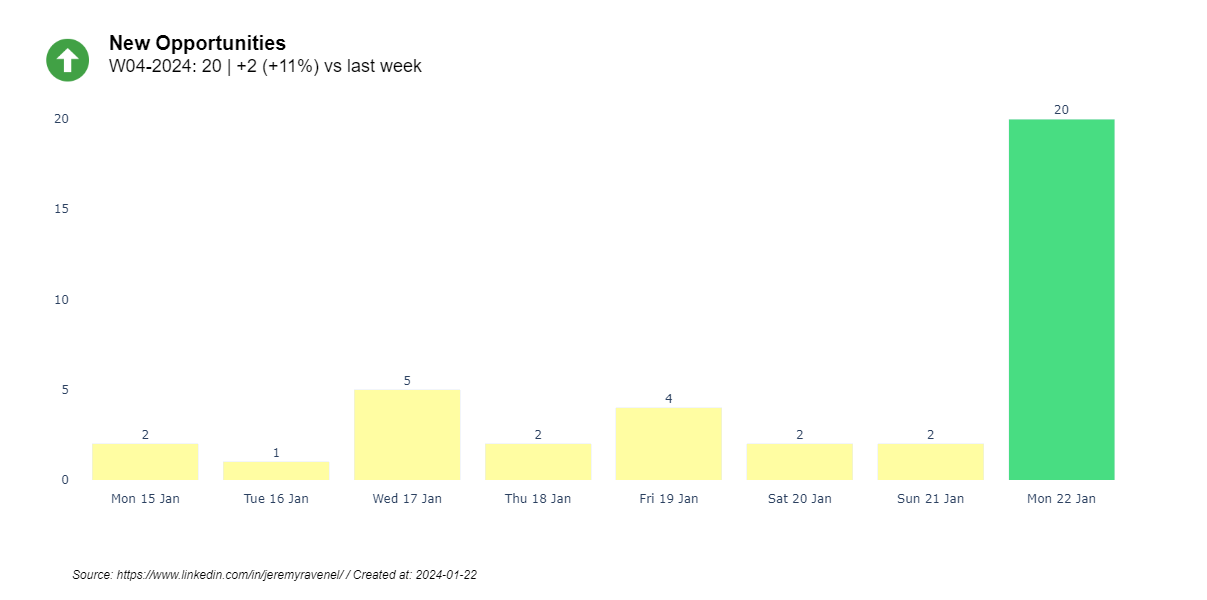

In [15]:
def get_week_number(week):
    return int(week.split("W")[1].split("-")[0]) 

def create_barchart(
    df,
    label,
    groups,
    value,
    title,
    logo,
):
    # Init
    fig = go.Figure()
    tw_int = get_week_number(TW)
    
    # Create trace
    list_groups = df[groups].unique()
    for group in list_groups:
#         showlegend = True
        tmp_df = df[df[groups] == group]
        # Create bar
        fig.add_trace(
            go.Bar(
                x=tmp_df[label],
                y=tmp_df[value],
                name=group,
                marker=dict(color=tmp_df["COLOR"]),
                text=tmp_df[value],
                textposition="outside",
                hoverinfo="text",
                hovertext=tmp_df["TEXT"],
                showlegend=False
            )
        )

    # Add logo
    fig.add_layout_image(
        dict(
            source=logo,
            xref="paper",
            yref="paper",
            x=0.01,
            y=1.045,
            sizex=0.12,
            sizey=0.12,
            xanchor="right",
            yanchor="bottom",
        )
    )
    
    # Add annotation
    fig.add_annotation(
        text=f"<i>Source: <a href='{linkedin_url}'>{linkedin_url}</a> / Created at: {date.today().isoformat()}</i>",
        font=dict(family="Arial", color="black"),
        x=0,
        y=-0.35,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="bottom",
        arrowcolor="white",
    )
    # Update layout
    fig.update_layout(
        title=title,
        title_x=0.09,
        title_font=dict(family="Arial", color="black"),
        paper_bgcolor="#ffffff",
        plot_bgcolor="#ffffff",
        width=1200,
        height=600,
        margin_pad=10,
        margin_b=120,
        barmode="stack",
        bargap=0.1,  # gap between bars of adjacent location coordinates.
        bargroupgap=0.1,  # gap between bars of the same location coordinate.
    )
    config = {"displayModeBar": False}
    fig.show(config=config)
    return fig

fig = create_barchart(df_trend, label="DATE_D", groups="SCENARIO", value="VALUE", title=title_full, logo=logo)

## Output

### Save data

In [16]:
pdump(output_dir, df_trend, csv_output)

### Save and share your graph in HTML


In [17]:
# Save your graph in HTML
fig.write_html(html_output)

# Share output with naas
html_link = naas.asset.add(html_output, params={"inline": True})

# -> Uncomment the line below to remove your asset
# naas.asset.delete(html_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Save and share your graph in image


In [18]:
# Save your graph in PNG
fig.write_image(image_output)

# Share output with naas
image_link = naas.asset.add(image_output, override_prod=True)

# -> Uncomment the line below to remove your asset
# naas.asset.delete(image_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete
